# Assignment 1: Evaluating Language Technologies
This assignment must be completed in order to be considered for enrollment in the class. If you are already enrolled, failure to complete this assignment will results in your removal from the course.

## Introduction
In this assignment, we will explore different tasks core to the field of NLP. You will implement different evaluation metrics for these tasks and perform analysis of different language
technologies.

Learning objectives:
* Understand the breadth of tasks core to the field of NLP.
* Implement various evaluation methods for core NLP tasks.
* Become familiar with prompting existing LLMs via API calls.
* Identify the limitations of automatic evaluation methods.
* Practice using error analysis to identify where language technologies fail and hypothesizing why they might fail.
* Appreciate things we humans do with language that current language models cannot do.

**Notes:**
* In your solution, keep all code as-is except where it's explicitly mentioned to implement a function.
* Items marked with a star (★) should be answered in markdown text in the notebook. You will include your final notebook as a pdf with your submission.
* We will automatically save files with results to the results sub-directory, these will be used for autograding. You should submit the results directory with your assignment on gradescope.

**Submission:**

You will submit:

* A PDF copy of your completed notebook. This should be titled "HW1.pdf". This is used to grade your answers to the problems marked with a (★).
* All the json files saved inside the `results/` directory. These will be autograded.

**Setup:**
You will need to download ollama https://ollama.com and install the following models with the commands:

`ollama pull gpt-oss:20b`

`ollama pull llama3.2:1b`

`ollama pull llama3.2`

`ollama pull gemma3:1b`

`ollama pull gemma3:4b`

You will need about 30Gb of storage to download these models. Make sure the ollama binary is in /usr/local/bin/ or you know where it is, so you can call it on the command line.

In [1]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 2.1 MB/s eta 0:00:00


In [2]:
%load_ext colabxterm

In [3]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [1]:
! ollama list

/bin/bash: line 1: ollama: command not found


In [8]:
! git clone https://github.com/Sea-Snell/cs183-283a-assignments-public.git

Cloning into 'cs183-283a-assignments-public'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 64 (delta 25), reused 62 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (64/64), 1.88 MiB | 12.45 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [10]:
%cd cs183-283a-assignments-public

/content/cs183-283a-assignments-public


In [11]:
%cd assignment1

/content/cs183-283a-assignments-public/assignment1


## Part 0: Setup

In [13]:
import pandas as pd
from pandas.core.frame import DataFrame
import aiohttp
import asyncio
import json
from tqdm import tqdm
from typing import Dict
import os

def save_results(results, filename):
    with open(filename, "w") as f:
        json.dump(results, f, indent=4)

async def run_inference(model_name, prompt, temperature=0.0, max_tokens=16):
    """
    curl http://localhost:11434/api/generate -d '{
		"model": "llama3.2",
		"prompt":"Why is the sky blue?",
		"stream": false,
	}'
    """
    async with aiohttp.ClientSession() as session:
        async with session.post(
            "http://localhost:11434/api/generate",
            json={
                "model": model_name,
                "prompt": prompt,
                "stream": False,
                "options": {
                    "temperature": temperature,
                    "num_predict": max_tokens,
                },
            }
        ) as response:
            result = await response.json()
            return result.get("response", "")

async def run_batch_inference(model_name, prompts, temperature=0.0, max_tokens=16):
    progress = tqdm(total=len(prompts))
    async def _run_inference(prompt):
        result = await run_inference(model_name, prompt, temperature, max_tokens)
        progress.update(1)
        return result
    tasks = [_run_inference(prompt) for prompt in prompts]
    return await asyncio.gather(*tasks)

def cache_inferences(model_name, exp_name, prompts, inferences):
    if os.path.exists(f"inference_cache/{model_name}_{exp_name}.json"):
        with open(f"inference_cache/{model_name}_{exp_name}.json", "r") as f:
            cache = json.load(f)
            cache.update(dict(zip(prompts, inferences)))
    else:
        cache = dict(zip(prompts, inferences))
    with open(f"inference_cache/{model_name}_{exp_name}.json", "w") as f:
        json.dump(cache, f)

def load_inferences(model_name, exp_name, prompts):
    if os.path.exists(f"inference_cache/{model_name}_{exp_name}.json"):
        with open(f"inference_cache/{model_name}_{exp_name}.json", "r") as f:
            cache = json.load(f)
            return [cache[prompt] if prompt in cache else None for prompt in prompts]
    return [None for _ in prompts]

def get_remaining_prompts(model_name, exp_name, prompts):
    if os.path.exists(f"inference_cache/{model_name}_{exp_name}.json"):
        with open(f"inference_cache/{model_name}_{exp_name}.json", "r") as f:
            cache = json.load(f)
            return [prompt for prompt in prompts if prompt not in cache]
    return prompts

models = [
    "llama3.2:1b" ,
    "llama3.2",
    "gemma3:1b",
    "gemma3:4b",
]

## Part 1: Text classification (25 points)
Here, we will evaluate different LLMs on their ability to perform newsgroup classification. You will implement four standard metrics for evaluating a classifier and create a visualization of the errors using a confusion matrix. We will be using a classic NLP dataset, 20 Newsgroups (http://qwone.com/~jason/20Newsgroups/).

### Part 1.0: Setup
Load the data we will be using for evaluation. This is the development set of the dataset, so it's ok for us to do analysis with it.

We will load the possible labels from the training set, rather than the development set. If a new label has to be predicted at test-time, we wouldn't have learned it from training only on the training set!

In [14]:
classification_inputs = pd.read_csv('A1_Data/dev_data.csv')
classification_labels = pd.read_csv('A1_Data/dev_labels.csv')
classification_data = pd.merge(classification_inputs, classification_labels, on="id", how="inner")[:200]

print(f"Loaded newsgroup data of shape {classification_data.shape} with columns {classification_data.columns.tolist()}.")

labels = pd.read_csv('A1_Data/train_labels.csv')["newsgroup"].unique()
label_list = ", ".join(sorted(list(labels)))

print(f"Found {len(labels)} possible target labels: ")
print(label_list)

Loaded newsgroup data of shape (200, 3) with columns ['id', 'text', 'newsgroup'].
Found 20 possible target labels: 
alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc


Now let's run inference with the different classifiers. It will take some time to run inference.

In [16]:
def get_newsgroup_prompt(text):
	newsgroup_prompt = "In which of the following newsgroups is the following email most likely to appear? Output only the newsgroup name, no other text."
	newsgroup_prompt += f"\n\nNewsgroups:\n{label_list}\n\nEmail:\n{text}"
	return newsgroup_prompt

prompts = [get_newsgroup_prompt(text) for text in classification_data["text"]]
for model in models:
	print(f"Running inference for {model}")
	remaining_prompts = get_remaining_prompts(model, "pt1_0_classification_data", prompts)
	curr_inferences = await run_batch_inference(model, remaining_prompts, temperature=0.0, max_tokens=16)
	cache_inferences(model, "pt1_0_classification_data", remaining_prompts, curr_inferences)
	inferences = load_inferences(model, "pt1_0_classification_data", prompts)
	classification_data[f"predictions_{model}"] = inferences

Running inference for llama3.2:1b



0it [00:00, ?it/s]


Running inference for llama3.2



0it [00:00, ?it/s]


Running inference for gemma3:1b



0it [00:00, ?it/s]


Running inference for gemma3:4b



0it [00:00, ?it/s]


In [17]:
classification_data

,id,text,newsgroup,predictions_llama3.2:1b,predictions_llama3.2,predictions_gemma3:1b,predictions_gemma3:4b
0,0,From: tim@kimba.catt.citri.edu.au (Tim Liddelo...,comp.windows.x,talk.politics.misc,comp.sys.ibm.pc.hardware,alt.atheism\n,comp.os.ms-windows.misc\n
1,1,From: petrack@vnet.IBM.COM\nSubject: disabling...,comp.sys.mac.hardware,talk.politics.misc,talk.politics.misc,alt.atheism\n,comp.os.ms-windows.misc\n
2,2,From: Lars.Jorgensen@p7.syntax.bbs.bad.se (Lar...,comp.graphics,talk.politics.misc,talk.religion.misc,comp.os.ms-windows.misc,comp.os.ms-windows.misc\n
3,3,From: dnh@mfltd.co.uk (Des Herriott)\nSubject:...,comp.windows.x,talk.politics.misc,talk.politics.misc,alt.atheism,comp.os.ms-windows.misc\n
4,4,From: willisw@willisw.ENG.CLEMSON.edu (Bill Wi...,comp.sys.ibm.pc.hardware,talk.politics.guns,talk.religion.misc,alt.atheism\n,comp.os.ms-windows.misc
...,...,...,...,...,...,...,...
195,195,From: fox@graphics.cs.nyu.edu (David Fox)\nSub...,soc.religion.christian,talk.politics.misc,alt.atheism,alt.atheism,alt.atheism\n
196,196,From: moor9881@mach1.wlu.ca (Dwayne Moore u)\n...,comp.os.ms-windows.misc,talk.politics.misc,comp.sys.ibm.pc.hardware,comp.sys.ibm.pc.soundcard\n,comp.os.ms-windows.misc\n
197,197,From: nsmca@aurora.alaska.edu\nSubject: Re: ar...,sci.space,sci.electronics,talk.politics.military,alt.atheism,comp.sys.ibm.pc.hardware\n
198,198,From: ohayon@jcpltyo.JCPL.CO.JP (Tsiel Ohayon)...,talk.politics.mideast,talk.politics.guns,talk.politics.misc,rec.autos,alt.atheism


### Part 1.1: Confusion Matrix (5 points)
Complete the following functions. The first one should computes a confusion matrix for a set of predictions, and the second one should use your favorite tool (e.g. Matplotlib) to visualize it as a heatmap.

We're implementing the confusion matrix first because you might find it useful when completing the rest of Part 1.

If the model messes up the output format (e.g. outputs something that isn't one of the labels), the prediction should not be included in the matrix counts.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from typing import Dict
import pandas as pd

def part1_1_cm(x: DataFrame, y: str) -> Dict[str, Dict[str, int]]:
    # Get list of possible true labels
    true_labels = x['newsgroup'].unique().tolist()
    # Initialize confusion matrix dictionary: true_label -> predicted_label -> count
    cm = {true_label: {pred_label: 0 for pred_label in true_labels} for true_label in true_labels}

    for _, row in x.iterrows():
        true_label = row['newsgroup']
        pred_label = row.get(f'predictions_{y}', None)
        # Skip if prediction is missing or not in known labels
        if pred_label is None or pred_label not in true_labels:
            continue
        cm[true_label][pred_label] += 1

    return cm

def part_1_1_vis(x: Dict[str, Dict[str, int]]):
    # Convert nested dict to DataFrame for heatmap
    cm_df = pd.DataFrame(x).T  # transpose so rows are true labels, columns are predicted labels
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

  0%|          | 0/200 [12:48<?, ?it/s]


Now we'll use these functions to compute and visualize confusion matrices for each classifier.

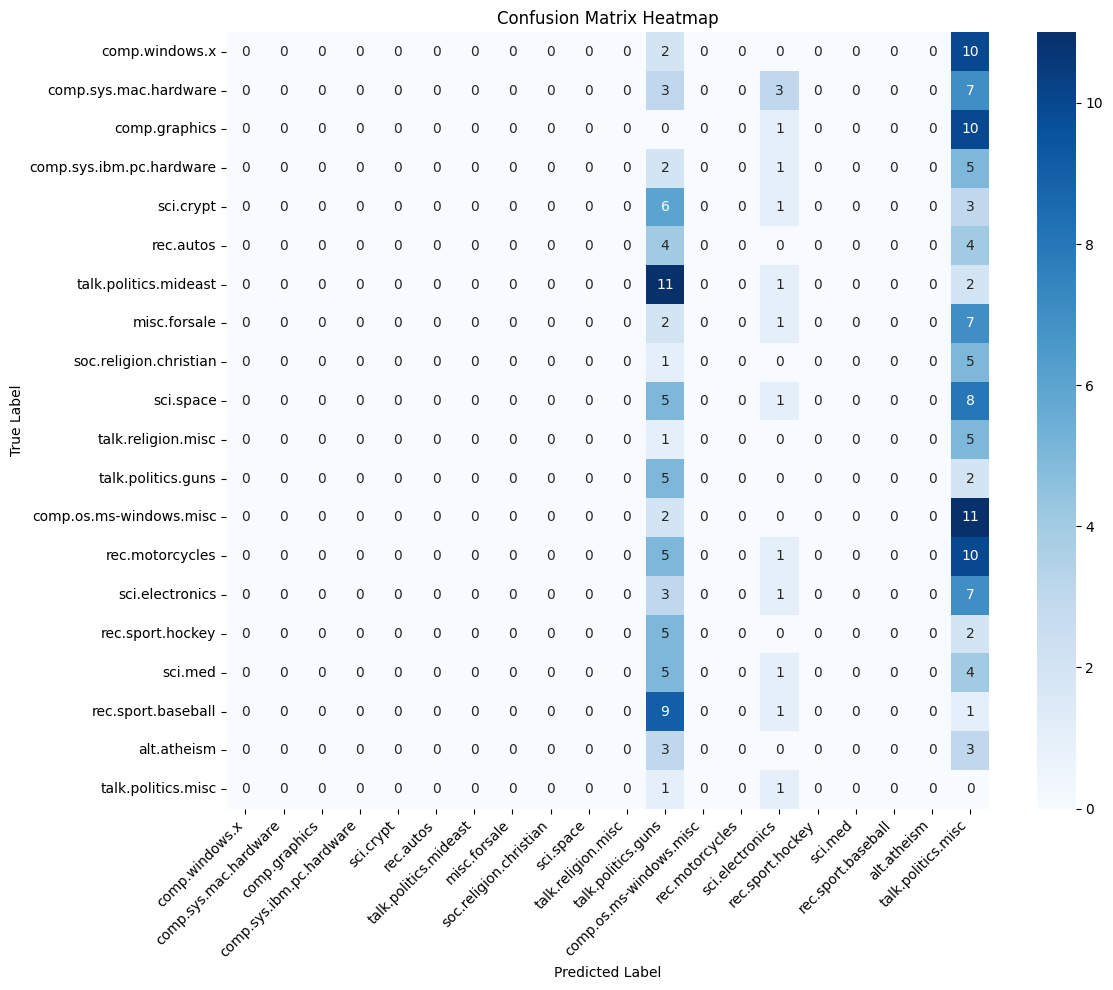

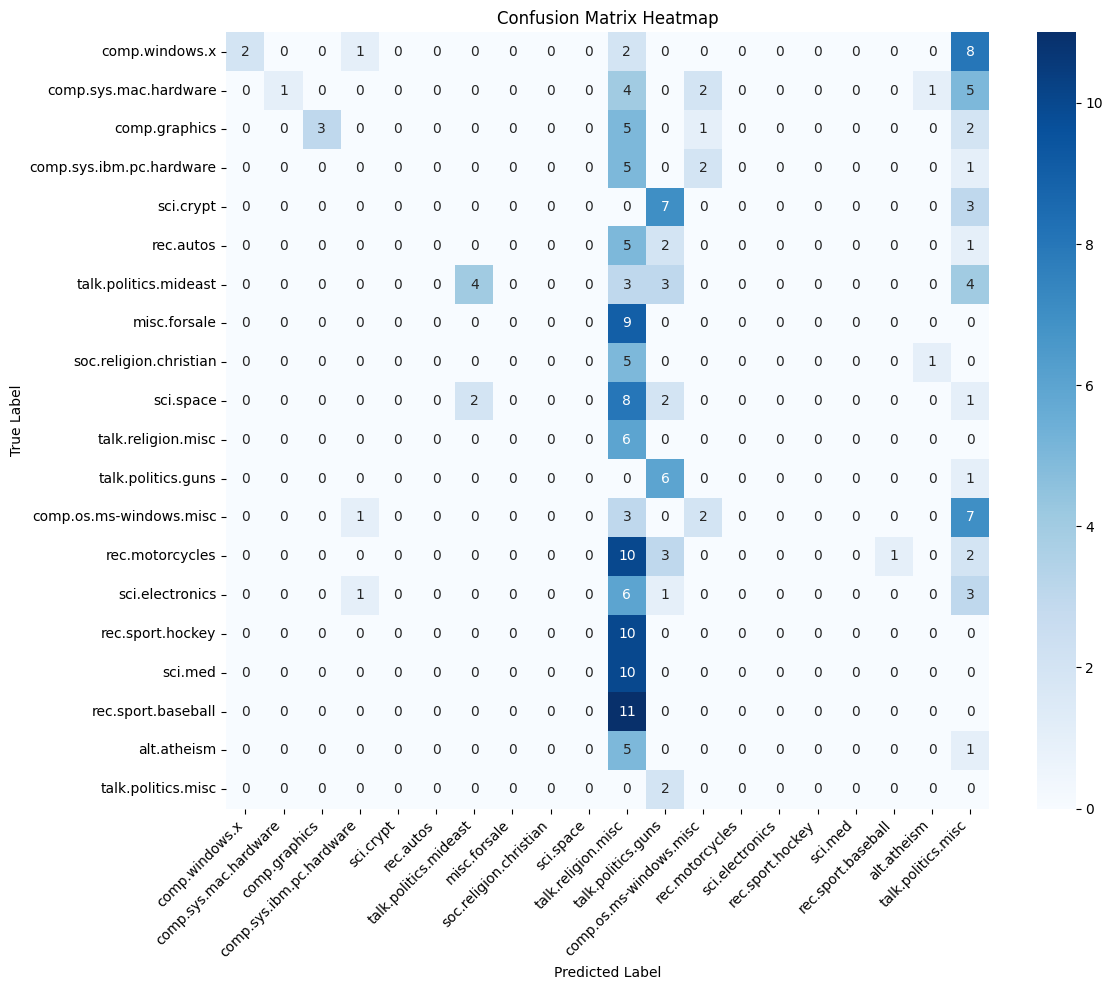

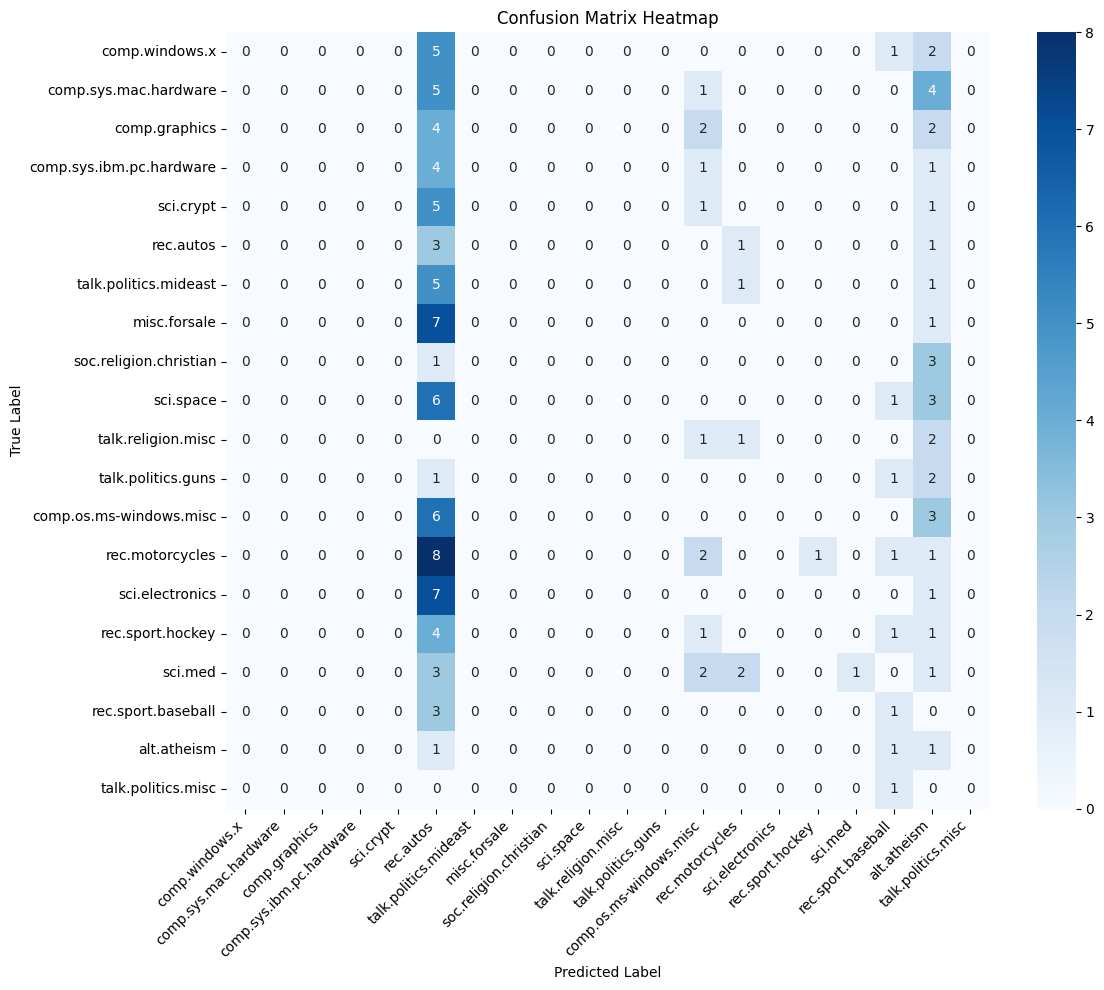

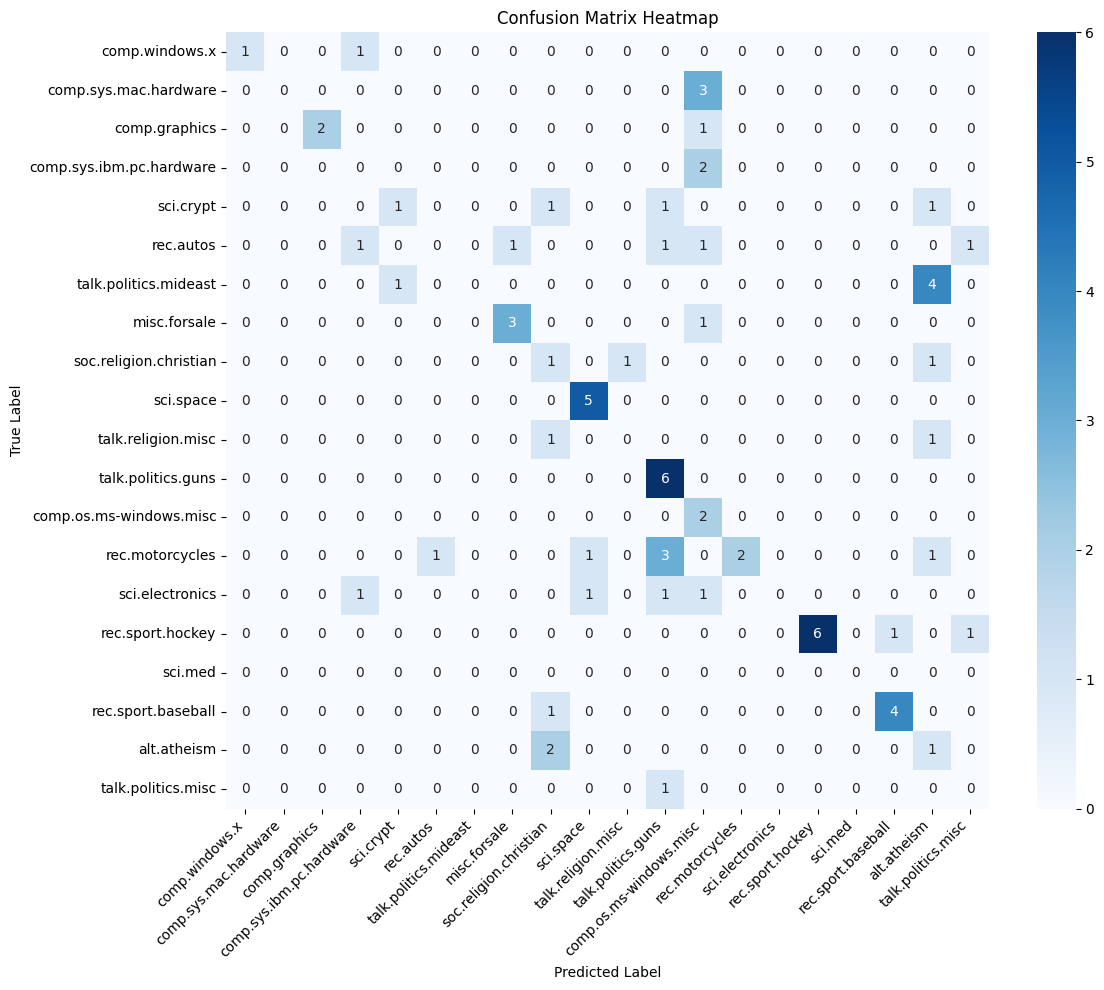

In [23]:
confusion_matrices = dict()

for model in models:
    confusion_matrices[model] = part1_1_cm(classification_data, model)
    part_1_1_vis(confusion_matrices[model])

★ Make sure the images are rendered in the notebook pdf you submit.

★ For each of the different classifiers, which pair of classes is most often confused?

★ Use the scratch space below to explore the documents that are misclassified most often with these class pairings, and include snippets of a few examples below.

★ Why might these pairs of classes be more difficult for the classifiers to distinguish?

In [25]:
# TODO: Use this scratch space to find documents
# that are examples of common misclassfications
# Find examples where true label is 'rec.autos' but predicted label is 'comp.os.ms-windows.misc'
mask = (classification_data['newsgroup'] == 'rec.autos') & (classification_data['predictions_llama3.2:1b'] == 'comp.os.ms-windows.misc')
for idx, row in classification_data[mask].iterrows():
    print(f"Text: {row['text'][:200]}...\nTrue Label: {row['newsgroup']} | Prediction: {row['predictions_llama3.2:1b']}\n")

print(classification_data['predictions_llama3.2:1b'].unique())



['talk.politics.misc' 'talk.politics.guns' 'sci.electronics'
 "It looks like you've provided a list of players from the National Hockey League ("
 'talk.politics.hockey' 'talk.windows.x']


Many classes are most often confused because they share similar vocabulary and subject matter. For example, computer hardware and operating system discussions often use overlapping technical terms that confuse classifiers.

Posts that lack distinctive jargon or mix topics tend to be harder for models to classify correctly. Additionally, some classes appear more frequently in training data, causing models to bias toward these dominant categories.

### Part 1.2: Accuracy (5 points)
Complete the following function, then use it to compute and compare the accuracies of each classifier.

★ Generate a table comparing the accuracy of each of the classifier systems.

★ Which one has the highest accuracy?

In [27]:
def part1_2_acc(x: DataFrame, y: str) -> float:
    true_labels = x['newsgroup']
    pred_labels = x[f'predictions_{y}']

    # Create boolean mask where predictions match true labels
    matches = (pred_labels == true_labels)

    # Compute accuracy as fraction correct (skip None or invalid predictions)
    valid_mask = pred_labels.isin(true_labels)

    if valid_mask.sum() == 0:
        return 0.0

    accuracy = matches[valid_mask].sum() / valid_mask.sum()
    return accuracy

accuracies: dict[str, float] = dict()

for model in models:
    accuracies[model] = part1_2_acc(classification_data, model)

save_results(accuracies, "results/accuracies.json")

best_model = max(accuracies, key=accuracies.get) # TODO: Which model performed the best?
best_model

'gemma3:4b'

### Part 1.3: Precision (5 points)
Complete the following function that returns, for each class, the precision of the classifier's labels given ground-truth labels. (note: if there are no predictions for a given class, then precision should be 0)

★ Generate a table showing, for the best-performing classifier, the precision of its labels across each class.

★ For which class are its labels the most accurate? The least?

In [29]:
def part1_3_prec(x: DataFrame, y: str) -> dict[str, float]:
    true_labels = x['newsgroup']
    pred_labels = x[f'predictions_{y}']

    labels = sorted(true_labels.unique())
    precision_dict = {}

    for label in labels:
        # Select all instances predicted as this label
        pred_as_label = (pred_labels == label)
        if pred_as_label.sum() == 0:
            precision_dict[label] = 0.0
            continue

        # Precision = true positives / (true positives + false positives)
        true_positives = ((true_labels == label) & pred_as_label).sum()
        precision = true_positives / pred_as_label.sum()
        precision_dict[label] = precision

    return precision_dict

best_model_prec = part1_3_prec(classification_data, best_model)

save_results(best_model_prec, "results/best_model_prec.json")

# TODO: Scratch space for analyzing the precision.

best_model_prec


{'alt.atheism': np.float64(0.1111111111111111),
 'comp.graphics': np.float64(1.0),
 'comp.os.ms-windows.misc': np.float64(0.18181818181818182),
 'comp.sys.ibm.pc.hardware': np.float64(0.0),
 'comp.sys.mac.hardware': 0.0,
 'comp.windows.x': np.float64(1.0),
 'misc.forsale': np.float64(0.75),
 'rec.autos': np.float64(0.0),
 'rec.motorcycles': np.float64(1.0),
 'rec.sport.baseball': np.float64(0.8),
 'rec.sport.hockey': np.float64(1.0),
 'sci.crypt': np.float64(0.5),
 'sci.electronics': 0.0,
 'sci.med': 0.0,
 'sci.space': np.float64(0.7142857142857143),
 'soc.religion.christian': np.float64(0.16666666666666666),
 'talk.politics.guns': np.float64(0.46153846153846156),
 'talk.politics.mideast': 0.0,
 'talk.politics.misc': np.float64(0.0),
 'talk.religion.misc': np.float64(0.0)}

### Part 1.4: Recall (5 points)
Complete the following function that returns, for each target class, the recall of the classifier's labels. (note: if there are no ground truth labels for a given class, the recall should be 0)

★ Generate a table showing, for each target class, the recall of the best-performing model's labels across each class.

★ For which class is recall the highest? The lowest?

In [30]:
def part1_4_rec(x: DataFrame, y: str) -> dict[str, float]:
    true_labels = x['newsgroup']
    pred_labels = x[f'predictions_{y}']
    labels = sorted(true_labels.unique())
    recall_dict = {}
    for label in labels:
        # Select all instances with true label == label
        actual = (true_labels == label)
        if actual.sum() == 0:
            recall_dict[label] = 0.0
            continue
        # Recall = true positives / total actual
        true_positives = ((pred_labels == label) & actual).sum()
        recall_dict[label] = true_positives / actual.sum()
    return recall_dict

best_model_rec = part1_4_rec(classification_data, best_model)

save_results(best_model_rec, "results/best_model_rec.json")

best_model_rec
# TODO: Scratch space for analyzing the recall.

{'alt.atheism': np.float64(0.16666666666666666),
 'comp.graphics': np.float64(0.18181818181818182),
 'comp.os.ms-windows.misc': np.float64(0.15384615384615385),
 'comp.sys.ibm.pc.hardware': np.float64(0.0),
 'comp.sys.mac.hardware': np.float64(0.0),
 'comp.windows.x': np.float64(0.07692307692307693),
 'misc.forsale': np.float64(0.3),
 'rec.autos': np.float64(0.0),
 'rec.motorcycles': np.float64(0.125),
 'rec.sport.baseball': np.float64(0.36363636363636365),
 'rec.sport.hockey': np.float64(0.5454545454545454),
 'sci.crypt': np.float64(0.1),
 'sci.electronics': np.float64(0.0),
 'sci.med': np.float64(0.0),
 'sci.space': np.float64(0.35714285714285715),
 'soc.religion.christian': np.float64(0.16666666666666666),
 'talk.politics.guns': np.float64(0.8571428571428571),
 'talk.politics.mideast': np.float64(0.0),
 'talk.politics.misc': np.float64(0.0),
 'talk.religion.misc': np.float64(0.0)}

### Part 1.5: F1 (5 points)

A weighted average F1 score computes an average F1 score over all target classes, weighted by the true number of instances of that class:

![test](https://github.com/Sea-Snell/cs183-283a-assignments-public/blob/main/assignment1/A1_Data/f1.png?raw=1)

Here, *f* is a classification function, *C* is the set of classes, *D* is the set of evaluation data with ground-truth labels, and *D_c* is the set of data whose ground-truth label is *c*.

Implement two functions below:
* A function that returns, for a target class, the F1 of a classifier's labels given ground truth labels
* A function that uses the previous function to compute a weighted average F1 score

In [31]:
def part1_5_class_f1(x: pd.DataFrame, y: str, z: str) -> float:
    true_labels = x['newsgroup']
    pred_labels = x[f'predictions_{y}']

    # Calculate precision for class z
    pred_as_z = (pred_labels == z)
    if pred_as_z.sum() == 0:
        precision = 0.0
    else:
        true_positives = ((true_labels == z) & pred_as_z).sum()
        precision = true_positives / pred_as_z.sum()

    # Calculate recall for class z
    actual_z = (true_labels == z)
    if actual_z.sum() == 0:
        recall = 0.0
    else:
        true_positives = ((pred_labels == z) & actual_z).sum()
        recall = true_positives / actual_z.sum()

    if precision + recall == 0:
        return 0.0
    f1 = 2 * precision * recall / (precision + recall)
    return f1

def part1_5_weighted_f1(x: pd.DataFrame, y: str) -> float:
    true_labels = x['newsgroup']
    labels = sorted(true_labels.unique())
    total = len(x)
    weighted_f1 = 0.0

    for label in labels:
        class_count = (true_labels == label).sum()
        weight = class_count / total if total > 0 else 0
        f1_score = part1_5_class_f1(x, y, label)
        weighted_f1 += weight * f1_score

    return weighted_f1


★ Generate a table comparing the weighted F1 score of each classifier.

★ Which is the best classifier according to weighted F1? How and why might this differ from an accuracy comparison (Part 1.2)?

In [33]:
f1s: dict[str, float] = dict()

for model in models:
    f1s[model] = part1_5_weighted_f1(classification_data, model)

save_results(f1s, "results/f1s.json")

# TODO: Scratch space for analyzing and reporting the F1.

## Part 2: Automatic speech recognition (25 points)
Here, we'll explore using a popular open-source automatic speech recognition system to compare its performance across English speakers whose native language differs.

### Part 2.0: Setup
First we'll download the Speech Accent Archive dataset (https://www.kaggle.com/datasets/rtatman/speech-accent-archive/data) -- it's about a 1GB download and may take some time to download and extract.

In [ ]:
import kagglehub
speech_accent_path = kagglehub.dataset_download("rtatman/speech-accent-archive")
speakers = pd.read_csv(f"{speech_accent_path}/speakers_all.csv")
language_counts = speakers['native_language'].value_counts()

languages_with_over_20_samples = set(language_counts[language_counts >= 20].index)
print(languages_with_over_20_samples)

Now let's load and run WhisperX to get predictions for each of the relevant audio files. This might take some time to load.

In [ ]:
import whisperx
whisperx_model = whisperx.load_model("tiny", "cpu", compute_type="float32", language="en")

Now let's run inference. This is the smallest model we could run inference on, so it's performance isn't going to be great. But, it shouldn't take *too* long to run on your local machine!

In [ ]:
import os
from tqdm import tqdm

transcriptions = {language: list() for language in languages_with_over_20_samples}

need_to_transcribe = False

if os.path.exists('transcriptions.tsv'):
    with open('transcriptions.tsv') as infile:
        for line in infile.readlines():
            language, transcript = line.strip().split("\t")
            transcriptions[language].append(transcript)

        for language, transcripts in transcriptions.items():
            if len(transcripts) != 20:
                need_to_transcribe = True
else:
    need_to_transcribe = True

if need_to_transcribe:
    recordings_filepath = f"{speech_accent_path}/recordings/recordings/"
    for language in languages_with_over_20_samples:
        print(f"Transcribing for native language {language}...")
        for i in tqdm(range(20)):
            filename = f"{language}{i + 1}.mp3"
            audio = whisperx.load_audio(f"{recordings_filepath}/{filename}")
            transcription = whisperx_model.transcribe(audio, language="en")
            transcriptions[language].append(transcription)

    with open("transcriptions.tsv", "w") as ofile:
        for language, transcripts in transcriptions.items():
            for transcript in transcripts:
                text = " ".join([segment["text"] for segment in transcript["segments"]])
                ofile.write(f"{language}\t{text}\n")

### Part 2.1: Word error rate (20 points)
Implement the following function to compute the word error rate for a candidate transcription given a reference. Each of the recordings we transcribed are readings of the same English text: *"Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station."*

In [ ]:
def part2_1(x: list[str], y: list[str]) -> float:
    # TODO: Implement this function.
    pass

Then let's evaluate for all of the candidate transcriptions and each of the native languages.

★ Generate a table comparing the average WER across each of the languages.

In [ ]:
import nltk
nltk.download('punkt_tab')

reference = "Please call Stella.  Ask her to bring these things with her from the store: " \
            "Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack " \
            "for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids. " \
            "She can scoop these things into three red bags, and we will go meet her Wednesday at the "\
            "train station."

language_wers = {language: list() for language in languages_with_over_20_samples}
for language, transcripts in transcriptions.items():
    for candidate in transcripts:
        language_wers[language].append(part2_1(nltk.word_tokenize(reference), nltk.word_tokenize(candidate)))

save_results(language_wers, "results/language_wers.json")

# TODO: Scratch space for computing average WER and generating a table to compare across native languages.

### Part 2.2: Error analysis (5 points)
★ Which languages have the lowest WER? Which have the highest?

★ Why might these languages have lower WER?

## Part 3: Machine translation (25 points)
In this part we will evaluate models on their abilities to translate text via BLEU score.

### Part 3.0: Setup


Prepare the dataset we will use for evaluation. This is a standard czech to english translation dataset. We will just use the first 25 examples for evaluation.

In [ ]:
from datasets import load_dataset

hf_dataset_cs = load_dataset("wmt/wmt19", "cs-en", split="validation")
hf_dataset_zh = load_dataset("wmt/wmt19", "zh-en", split="validation")
hf_dataset_gu = load_dataset("wmt/wmt19", "gu-en", split="validation")

dataset_items_cs = []
for i, item in enumerate(list(hf_dataset_cs)[:25]):
    dataset_items_cs.append({
        'id': i,
        'czech_text': item['translation']['cs'],
        'english_text': item['translation']['en']
    })

dataset_items_zh = []
for i, item in enumerate(list(hf_dataset_zh)[:25]):
    dataset_items_zh.append({
        'id': i,
        'chinese_text': item['translation']['zh'],
        'english_text': item['translation']['en']
    })

dataset_items_gu = []
for i, item in enumerate(list(hf_dataset_gu)[:25]):
    dataset_items_gu.append({
        'id': i,
        'gujarati_text': item['translation']['gu'],
        'english_text': item['translation']['en']
    })

dataset_cs = pd.DataFrame(dataset_items_cs)
dataset_zh = pd.DataFrame(dataset_items_zh)
dataset_gu = pd.DataFrame(dataset_items_gu)
print(f"Loaded translation data of shape {dataset_cs.shape} with columns {dataset_cs.columns.tolist()}.")

We will use a simple nltk based tokenizer to encode the n-gram tokens for computing the bleu score.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

def tokenize_text(text):
    # Download required NLTK data if not already downloaded
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')

    # Tokenize the text into a list of tokens
    tokens = word_tokenize(text)
    return tokens


In [ ]:
tokenize_text("Welcome to CS-183: we are learning about NLP evaluations today!!!")

In [ ]:
dataset_cs.head()

In [ ]:
dataset_zh.head()

In [ ]:
dataset_gu.head()

now let's get the model predictions for these translations

In [ ]:
def get_translation_prompt(text):
	translation_prompt = "Translate the following text from Czech to English. Output only the translation, no other text."
	translation_prompt += f"\n\nText:\n{text}"
	return translation_prompt

prompts_cs = [get_translation_prompt(text) for text in dataset_cs["czech_text"]]
for model in models:
	print(f"Running inference for {model}")
	remaining_prompts = get_remaining_prompts(model, "pt3_1_translation_data_cs", prompts_cs)
	curr_inferences = await run_batch_inference(model, remaining_prompts, temperature=0.0, max_tokens=512)
	cache_inferences(model, "pt3_1_translation_data_cs", remaining_prompts, curr_inferences)
	inferences = load_inferences(model, "pt3_1_translation_data_cs", prompts_cs)
	dataset_cs[f"predictions_{model}"] = inferences

prompts_zh = [get_translation_prompt(text) for text in dataset_zh["chinese_text"]]
for model in models:
	print(f"Running inference for {model}")
	remaining_prompts = get_remaining_prompts(model, "pt3_1_translation_data_zh", prompts_zh)
	print(f"Remaining prompts: {len(remaining_prompts)}")
	curr_inferences = await run_batch_inference(model, remaining_prompts, temperature=0.0, max_tokens=512)
	cache_inferences(model, "pt3_1_translation_data_zh", remaining_prompts, curr_inferences)
	inferences = load_inferences(model, "pt3_1_translation_data_zh", prompts_zh)
	dataset_zh[f"predictions_{model}"] = inferences

prompts_gu = [get_translation_prompt(text) for text in dataset_gu["gujarati_text"]]
for model in models:
	print(f"Running inference for {model}")
	remaining_prompts = get_remaining_prompts(model, "pt3_1_translation_data_gu", prompts_gu)
	curr_inferences = await run_batch_inference(model, remaining_prompts, temperature=0.0, max_tokens=512)
	cache_inferences(model, "pt3_1_translation_data_gu", remaining_prompts, curr_inferences)
	inferences = load_inferences(model, "pt3_1_translation_data_gu", prompts_gu)
	dataset_gu[f"predictions_{model}"] = inferences

In [ ]:
dataset_cs

In [ ]:
dataset_zh

In [ ]:
dataset_gu

### Part 3.1 n-gram precision (5 points)

complete the following function to calculate the n-gram prediction of a predicted translation given the reference.

In [ ]:

def ng_prec(pred, ref, n):
    # TODO: Implement this function.
    pass

### Part 3.2 brevity penalty (5 points)

complete the following function to calculate the brevity penalty for the bleu score

In [ ]:
def brev_pen(pred, ref):
    # TODO: Implement this function.
    pass

### Part 3.3 putting it together (10 points)

complete the following function to calculate the full bleu score, using the two functions from the previous parts. Represent the bleu score as discussed in class, using the 1, 2, 3, and 4 gram precisions.

In [ ]:
def bleu(pred, ref):
    # TODO: Implement this function.
    pass

★ Generate a table computing the bleu score for all model outputs for each language pair.

In [ ]:
bleu_scores_cs = {model: [] for model in models}
bleu_scores_zh = {model: [] for model in models}
bleu_scores_gu = {model: [] for model in models}

references_cs = dataset_cs['english_text']
references_zh = dataset_zh['english_text']
references_gu = dataset_gu['english_text']

for model in models:
    predictions_cs = dataset_cs[f'predictions_{model}']
    for reference, prediction in zip(references_cs, predictions_cs):
        bleu_scores_cs[model].append(bleu(prediction, reference))

    predictions_zh = dataset_zh[f'predictions_{model}']
    for reference, prediction in zip(references_zh, predictions_zh):
        bleu_scores_zh[model].append(bleu(prediction, reference))

    predictions_gu = dataset_gu[f'predictions_{model}']
    for reference, prediction in zip(references_gu, predictions_gu):
        bleu_scores_gu[model].append(bleu(prediction, reference))

save_results(bleu_scores_cs, "results/bleu_scores_cs.json")
save_results(bleu_scores_zh, "results/bleu_scores_zh.json")
save_results(bleu_scores_gu, "results/bleu_scores_gu.json")

# TODO: Scratch space for computing average BLEU and generating a table to compare across models.

### Part 3.4 Error Analysis (5 points)

★ Look at these and other lowest-scoring documents. Identify 3 types of errors this MT system seems to be making and show two example documents per error.

## Part 4: Open-ended text generation (25 points)

In this part we will evaluate open ended text using an LLM judge.

### Part 4.0: Setup

Here we list the prompts we will use for comparing LLMs. Since the judge should ideally be more powerful than the models generating the outputs, we will use the GPT-oss 20B model as the judge.

In [ ]:
prompts = [
	"Explain bleu score in 100 words or less.",
    "Why does bleu score use a brevity penalty?",
    "How is precision different from recall?",
    "Why would one want to use F1-score instead of accuracy?",
    "What are the best boba spots in Berkeley?",
    "Why would an LLM judge prefer one output over another?",
    "What does CS 61C at UC Berkeley teach?",
    "What do most students at UC Berkeley think of EE16a?",
    "What is the best place to get ramen in Berkeley?",
    "Write a poem about Berkeley.",
]

data = pd.DataFrame(prompts, columns=["prompt"])

judge_model = "gpt-oss:20b"

Get the outputs from each of the models for these prompts.

In [ ]:
outputs_per_model = {}
for model in models:
	print(f"Running inference for {model}")
	remaining_prompts = get_remaining_prompts(model, "pt3_1_pairwise_judgement_data", prompts)
	curr_inferences = await run_batch_inference(model, remaining_prompts, temperature=0.0, max_tokens=1024*8)
	cache_inferences(model, "pt3_1_pairwise_judgement_data", remaining_prompts, curr_inferences)
	inferences = load_inferences(model, "pt3_1_pairwise_judgement_data", prompts)
	outputs_per_model[model] = inferences

Have a look at some of the outputs

In [ ]:
# TODO use this scratch space to explore the model outputs
outputs_per_model

### Part 4.1 Pairwise judge (10 Points)

Let's implement a function that takes as input a prompt and two candidate generated texts and calls an LLM to judge which of the two texts is preferred.

We've implemented the prompt for the judge below. You should compute the head to head comparisons for all models across all prompt pairs. Include the pairwise judgement for each pair/prompt in the head_to_head_judgements object below.

In [ ]:
def get_pairwise_judgement_prompt(output1, output2):
	prompt = f"Which of the following two outputs is better? Output 1: {output1}. Output 2: {output2}. Output only the number 1 or 2, no other text."
	return prompt

head_to_head_judgements = [{str((model_a, model_b)): None for model_a in models for model_b in models if model_a != model_b} for _ in range(len(prompts))]

# TODO: impelemnt the head to head judgements

save_results(head_to_head_judgements, "results/head_to_head_judgements.json")

★ Which model performs best?

### Part 4.2: Attribute Evaluation (5 Points)

Instead of judging outputs in a pairwise fashion, let's instead implement a judge which takes a prompt and outputs a score on a scale of 1-5 for the following attributes:

* Style - is the output well written and entertaining, without being excessive or over the top in its style?
* Correctness - does the output contain only factually correct information?
* Brevity - is the output short and to the point and does not contain unnecessary slop?

This time you will write the prompt. Include your attrbite predictions in the output below.

In [ ]:
attribute_preds = [[{'style': None, 'correctness': None, 'brevity': None} for _ in models] for _ in prompts]

# TODO: Implement the attribute predictions

save_results(attribute_preds, "results/attribute_preds.json")

# TODO: Scratch space for computing average attribute scores and generating a table to compare across models.

★ Which models win on each attribute?

★ How do these results correlate with the head-to-head comparitons?

### Part 4.3: Human Evaluation and Error Analysis (5 Points)

★ How do your preferences and ratings correlate or don’t correlate with the LLM-as-a-judge labels?

★ What is one additional attribute you might want to evaluate via LLM-as-a-judge so that the evaluation better captures your preferences?

### Part 4.4: Prompt and Model Sensitivity (5 Points)

Re-run the head-to-head LLM-as-a-judge evaluation in Part 4.1, but instead re-phrase the prompt.

Include your outputs in the new_head_to_head_judgements object.

In [ ]:
new_head_to_head_judgements = [{str((model_a, model_b)): None for model_a in models for model_b in models if model_a != model_b} for _ in range(len(prompts))]

# TODO: Implement the new head to head judgements

save_results(new_head_to_head_judgements, "results/new_head_to_head_judgements.json")

★ How does the evaluation change when you change the prompt?

★ How might you adjust your evaluation methodology to account for this variation?

## Part 5: Frontier of Model Capabilities (optional; 10 bonus points)

In this optional part you will invent and evaluate a new task that you believe modern LLMs might struggle with.

### Part 5.1: Invent a new task (5 points)

Brainstorm a task that you think modern models might not be able to do (yet, or ever).

Report:

★ A natural language description of the task.

★ A few instances of the task, showing inputs and expected outputs.

### Part 5.1: Evaluate a model on this task (5 points)

How well do current models perform on this task?

Report:

★ Explain how you might evaluate this task. What challenges might arise in evaluation?

★ Try evaluating a frontier model (e.g. LLM, VLM) on this task. Which model did you
use? How did it perform? Show examples of its outputs. If it performed poorly, what do you think are the main challenges involved in task success that the model can’t capture?

## Homework Feedback (optional)

★ This is a new assignment so we are open to feedback. What was good/bad about this assignment? What should we have done differently?

## Academic integrity

You can discuss high-level solutions with classmates, but your submitted work should be your own. Don't copy from or share code with one another. Provide attribution for any sources of assistance you used in the assignment. If you use generative AI tools to aid in any parts of this assignment, describe how you used them and what worked (or didn't work) when using them.